cuda
Execution time: 0.4050724506378174 seconds
Accuracy statistics saved successfully.

Test Accuracy Real Part:
Average Distance: 0.0379
Maximum Distance: 0.0493
Minimum Distance: 0.0244

Test Accuracy Imaginary Part:
Average Distance: 0.0384
Maximum Distance: 0.0510
Minimum Distance: 0.0251
Predicted data saved successfully.


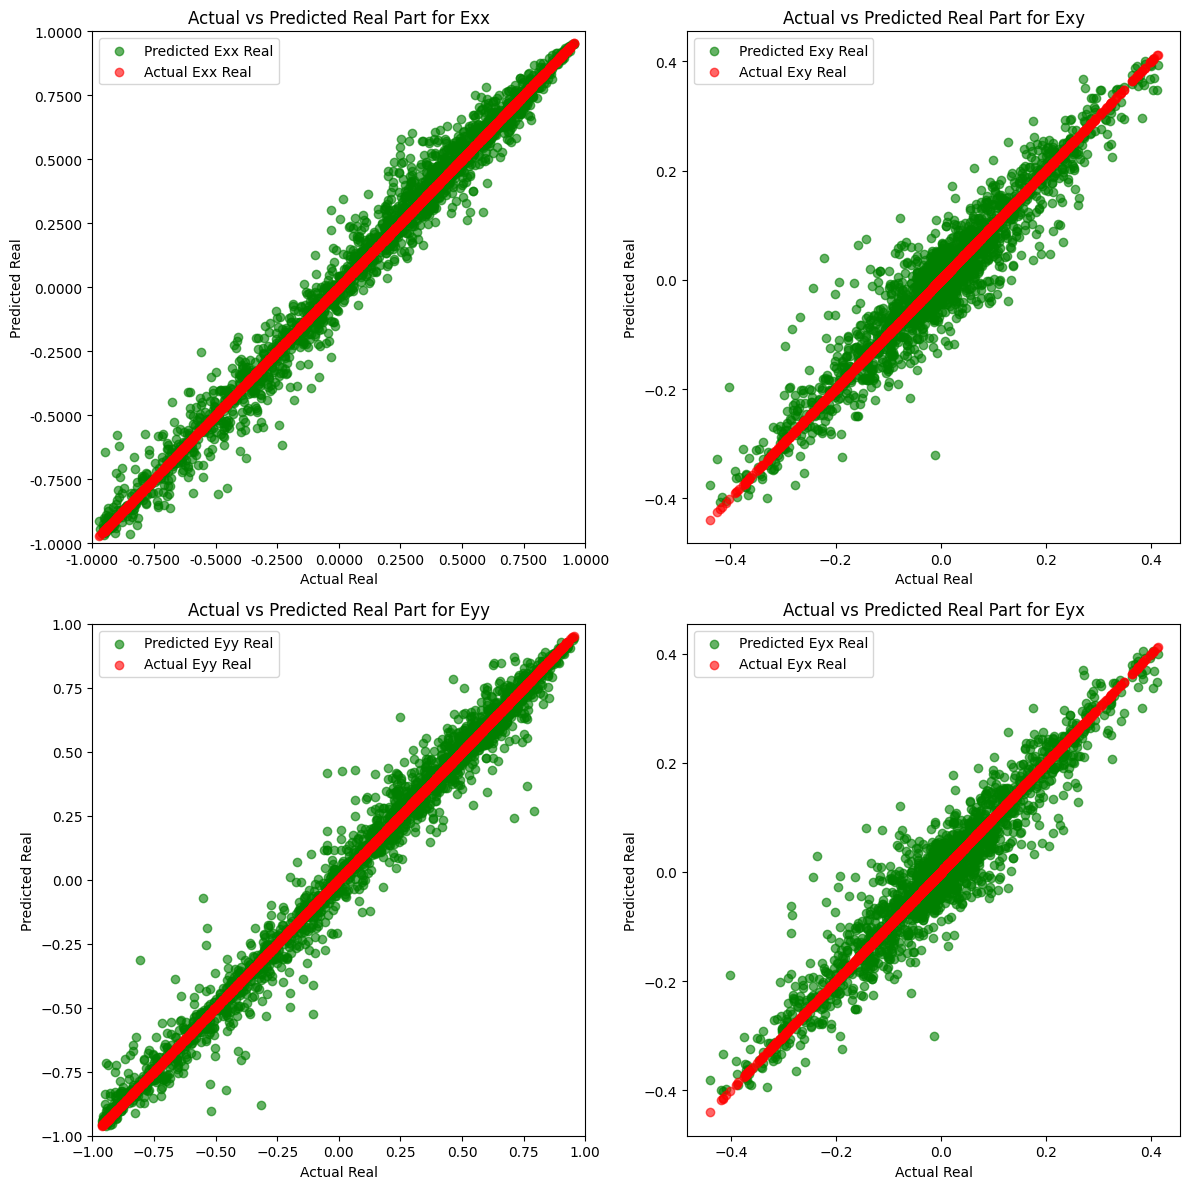

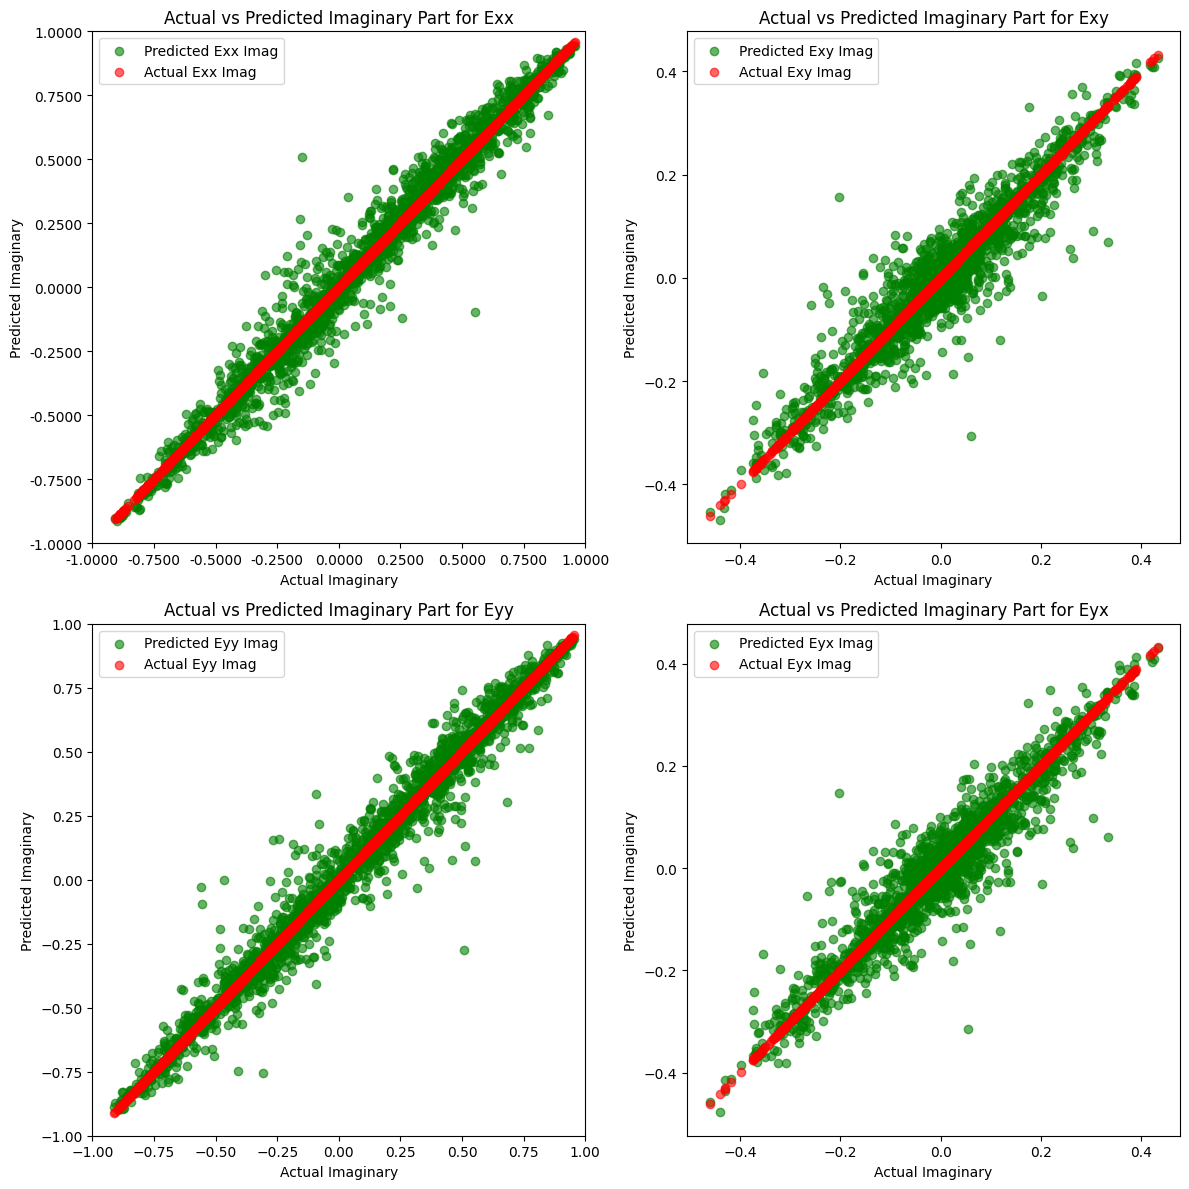

In [9]:
import time
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import re
import matplotlib.pyplot as plt
import pytz
from datetime import datetime
# Start time
start_time = time.time()

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


# Define the same model architecture
# Define ResNetBlock1
class ResNetBlock1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.identity_downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1,stride=1) if in_channels != out_channels else None

    def forward(self, x):
        identity = x
        if self.identity_downsample is not None:
            identity = self.identity_downsample(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = F.relu(out)
        return out


# Define ResNetBlock2
class ResNetBlock2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        identity = x
        if self.conv3 is not None:
            identity = self.conv3(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = F.relu(out)
        return out


# Define the entire network
class FinalCNN(nn.Module):
    def __init__(self):
        super(FinalCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = ResNetBlock1(in_channels=64, out_channels=64)
        self.layer2 = ResNetBlock2(in_channels=64, out_channels=128)
        self.layer3 = ResNetBlock1(in_channels=128, out_channels=256)
        self.layer4 = ResNetBlock2(in_channels=256, out_channels=128)
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, 1024)
        self.fc2 = nn.Linear(1024, 128)
        #self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 128)  # 64 for real and 64 for imaginary

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = torch.tanh(self.fc3(x))  # Clamping the output to be within [-1, 1]
        return x


# Function to process image file
def process_image_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    images = []
    image = []
    for line in lines:
        row = [int(pixel) for pixel in line.strip().split(',')]
        image.append(row)
        if len(image) == 64:
            images.append(image)
            image = []
    images = np.array(images, dtype=np.float32)
    images = images.reshape(-1, 1, 64, 64)  # -1 to automatically determine the number of images
    return images


file_path1 = '/notebooks/Simulator_Data/Test_metasurface_V1.txt'  
images = process_image_file(file_path1)


# Function to parse complex number
def parse_complex_number(s):
    complex_match = re.match(r'([+-]?\d+(\.\d+)?)([+-]\d+(\.\d+)?)i', s)
    if complex_match:
        real_part = float(complex_match.group(1))
        imag_part = float(complex_match.group(3))
        return complex(real_part, imag_part)
    real_match = re.match(r'([+-]?\d+(\.\d+)?)(?![i])', s)
    if real_match:
        real_part = float(real_match.group(1))
        return complex(real_part, 0)
    raise ValueError(f"Invalid complex number format: {s}")


file_path2 = '/notebooks/Simulator_Data/Test_label_complex_V1.txt'  
with open(file_path2, 'r') as file:
    lines = file.readlines()
complex_numbers = [parse_complex_number(num) for line in lines for num in line.strip().split()]

real_parts = [num.real for num in complex_numbers]
imag_parts = [num.imag for num in complex_numbers]

labels_real = np.array(real_parts, dtype=np.float32).reshape(-1, 64)
labels_imag = np.array(imag_parts, dtype=np.float32).reshape(-1, 64)


# Custom dataset class
class ImageDataset(Dataset):
    def __init__(self, images, labels_real, labels_imag):
        self.images = torch.tensor(images, dtype=torch.float32)
        self.labels_real = torch.tensor(labels_real, dtype=torch.float32)
        self.labels_imag = torch.tensor(labels_imag, dtype=torch.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label_real = self.labels_real[idx]
        label_imag = self.labels_imag[idx]
        return image, label_real, label_imag


dataset = ImageDataset(images, labels_real, labels_imag)
test_loader = DataLoader(dataset, batch_size=16, shuffle=False)

# Accuracy calculation function

def calculate_accuracy(actual, predicted):
    total_elements = np.prod(actual.shape)
    correct_predictions = np.sum(np.abs(actual - predicted) )
    accuracy = correct_predictions / total_elements
    return accuracy

# Load the saved model
model_path = '/notebooks/Simulator_trained/model_28_1039.pth'  # replace with your saved model path
model = FinalCNN().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()


# Run the model on the new test dataset
actual_real = []
actual_imag = []
predicted_real = []
predicted_imag = []
test_accuracies_real = []
test_accuracies_imag = []


with torch.no_grad():
    for images, labels_real, labels_imag in test_loader:
        images, labels_real, labels_imag = images.to(device), labels_real.to(device), labels_imag.to(device)
        outputs = model(images)
        outputs_real = outputs[:, :64]
        outputs_imag = outputs[:, 64:]

        actual_real.append(labels_real.cpu().numpy())
        actual_imag.append(labels_imag.cpu().numpy())
        predicted_real.append(outputs_real.cpu().numpy())
        predicted_imag.append(outputs_imag.cpu().numpy())
        test_accuracies_real.append(calculate_accuracy(labels_real.cpu().numpy(), outputs_real.cpu().numpy()))
        test_accuracies_imag.append(calculate_accuracy(labels_imag.cpu().numpy(), outputs_imag.cpu().numpy()))

# Convert collected lists to numpy arrays
actual_real = np.concatenate(actual_real, axis=0)
actual_imag = np.concatenate(actual_imag, axis=0)
predicted_real = np.concatenate(predicted_real, axis=0)
predicted_imag = np.concatenate(predicted_imag, axis=0)

# Combine real and imaginary parts to form complex numbers
actual_complex = actual_real + 1j * actual_imag
predicted_complex = predicted_real + 1j * predicted_imag

# Execution time
# End time
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")



finland_timezone = pytz.timezone('Europe/Helsinki')
current_time =datetime.now(finland_timezone).strftime('%d_%H%M')

# Calculate test accuracy
avg_test_accuracy_real = np.mean(test_accuracies_real)
avg_test_accuracy_imag = np.mean(test_accuracies_imag)
max_test_accuracy_real = np.max(test_accuracies_real)
max_test_accuracy_imag = np.max(test_accuracies_imag)
min_test_accuracy_real = np.min(test_accuracies_real)
min_test_accuracy_imag = np.min(test_accuracies_imag)

# Save accuracy statistics to a text file
with open(f'/notebooks/Test_result/accuracy_loss_statistics_{current_time}.txt', 'w') as f:
    f.write("Test Accuracy Real Part:\n")
    f.write(f"Average Distance: {avg_test_accuracy_real:.4f}\n")
    f.write(f"Maximum Distance: {max_test_accuracy_real:.4f}\n")
    f.write(f"Minimum Distance: {min_test_accuracy_real:.4f}\n\n")

    f.write("Test Accuracy Imaginary Part:\n")
    f.write(f"Average Distance: {avg_test_accuracy_imag:.4f}\n")
    f.write(f"Maximum Distance: {max_test_accuracy_imag:.4f}\n")
    f.write(f"Minimum Distance: {min_test_accuracy_imag:.4f}\n")
    
print("Accuracy statistics saved successfully.\n")
print("Test Accuracy Real Part:")
print(f"Average Distance: {avg_test_accuracy_real:.4f}")
print(f"Maximum Distance: {max_test_accuracy_real:.4f}")
print(f"Minimum Distance: {min_test_accuracy_real:.4f}\n")

print("Test Accuracy Imaginary Part:")
print(f"Average Distance: {avg_test_accuracy_imag:.4f}")
print(f"Maximum Distance: {max_test_accuracy_imag:.4f}")
print(f"Minimum Distance: {min_test_accuracy_imag:.4f}")


with open(f'/notebooks/Test_result/predicted_complex_{current_time}.txt', 'w') as f:
    for i in range(len(predicted_complex)):
        line = []
        for j in range(64):
            line.append(f"{predicted_complex[i, j].real:.4f}+{predicted_complex[i, j].imag:.4f}i")
        f.write("\t".join(line) + "\n")

print("Predicted data saved successfully.")

# Create scatter plots for actual vs predicted values for real and imaginary parts
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Exx Real
axs[0, 0].scatter(actual_real[:, :16].flatten(), predicted_real[:, :16].flatten(), color='green', label='Predicted Exx Real', alpha=0.6)
axs[0, 0].scatter(actual_real[:, :16].flatten(), actual_real[:, :16].flatten(), color='red', label='Actual Exx Real', alpha=0.6)
axs[0, 0].set_title('Actual vs Predicted Real Part for Exx')
axs[0, 0].set_xlabel('Actual Real')
axs[0, 0].set_ylabel('Predicted Real')
axs[0, 0].legend()
axs[0, 0].set_xlim([-1, 1])
axs[0, 0].set_ylim([-1, 1])
axs[0, 0].xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.4f}'))
axs[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.4f}'))
# Exy Real
axs[0, 1].scatter(actual_real[:, 16:32].flatten(), predicted_real[:, 16:32].flatten(), color='green', label='Predicted Exy Real', alpha=0.6)
axs[0, 1].scatter(actual_real[:, 16:32].flatten(), actual_real[:, 16:32].flatten(), color='red', label='Actual Exy Real', alpha=0.6)
axs[0, 1].set_title('Actual vs Predicted Real Part for Exy')
axs[0, 1].set_xlabel('Actual Real')
axs[0, 1].set_ylabel('Predicted Real')
axs[0, 1].legend()
axs[0, 0].xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.4f}'))
axs[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.4f}'))
# Eyy Real
axs[1, 0].scatter(actual_real[:, 32:48].flatten(), predicted_real[:, 32:48].flatten(), color='green', label='Predicted Eyy Real', alpha=0.6)
axs[1, 0].scatter(actual_real[:, 32:48].flatten(), actual_real[:, 32:48].flatten(), color='red', label='Actual Eyy Real', alpha=0.6)
axs[1, 0].set_title('Actual vs Predicted Real Part for Eyy')
axs[1, 0].set_xlabel('Actual Real')
axs[1, 0].set_ylabel('Predicted Real')
axs[1, 0].legend()
axs[1, 0].set_xlim([-1, 1])
axs[1, 0].set_ylim([-1, 1])
axs[0, 0].xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.4f}'))
axs[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.4f}'))
# Eyx Real
axs[1, 1].scatter(actual_real[:, 48:].flatten(), predicted_real[:, 48:].flatten(), color='green', label='Predicted Eyx Real', alpha=0.6)
axs[1, 1].scatter(actual_real[:, 48:].flatten(), actual_real[:, 48:].flatten(), color='red', label='Actual Eyx Real', alpha=0.6)
axs[1, 1].set_title('Actual vs Predicted Real Part for Eyx')
axs[1, 1].set_xlabel('Actual Real')
axs[1, 1].set_ylabel('Predicted Real')
axs[1, 1].legend()
axs[0, 0].xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.4f}'))
axs[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.4f}'))
plt.tight_layout()
plt.savefig(f'/notebooks/Test_result/actual_vs_predicted_real_{current_time}.png')
plt.show()

# Create subplots for actual vs predicted for imaginary parts
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Exx Imag
axs[0, 0].scatter(actual_imag[:, :16].flatten(), predicted_imag[:, :16].flatten(), color='green', label='Predicted Exx Imag', alpha=0.6)
axs[0, 0].scatter(actual_imag[:, :16].flatten(), actual_imag[:, :16].flatten(), color='red', label='Actual Exx Imag', alpha=0.6)
axs[0, 0].set_title('Actual vs Predicted Imaginary Part for Exx')
axs[0, 0].set_xlabel('Actual Imaginary')
axs[0, 0].set_ylabel('Predicted Imaginary')
axs[0, 0].legend()
axs[0, 0].set_xlim([-1, 1])
axs[0, 0].set_ylim([-1, 1])
axs[0, 0].xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.4f}'))
axs[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.4f}'))
# Exy Imag
axs[0, 1].scatter(actual_imag[:, 16:32].flatten(), predicted_imag[:, 16:32].flatten(), color='green', label='Predicted Exy Imag', alpha=0.6)
axs[0, 1].scatter(actual_imag[:, 16:32].flatten(), actual_imag[:, 16:32].flatten(), color='red', label='Actual Exy Imag', alpha=0.6)
axs[0, 1].set_title('Actual vs Predicted Imaginary Part for Exy')
axs[0, 1].set_xlabel('Actual Imaginary')
axs[0, 1].set_ylabel('Predicted Imaginary')
axs[0, 1].legend()
axs[0, 0].xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.4f}'))
axs[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.4f}'))
# Eyy Imag
axs[1, 0].scatter(actual_imag[:, 32:48].flatten(), predicted_imag[:, 32:48].flatten(), color='green', label='Predicted Eyy Imag', alpha=0.6)
axs[1, 0].scatter(actual_imag[:, 32:48].flatten(), actual_imag[:, 32:48].flatten(), color='red', label='Actual Eyy Imag', alpha=0.6)
axs[1, 0].set_title('Actual vs Predicted Imaginary Part for Eyy')
axs[1, 0].set_xlabel('Actual Imaginary')
axs[1, 0].set_ylabel('Predicted Imaginary')
axs[1, 0].legend()
axs[1, 0].set_xlim([-1, 1])
axs[1, 0].set_ylim([-1, 1])
axs[0, 0].xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.4f}'))
axs[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.4f}'))
# Eyx Imag
axs[1, 1].scatter(actual_imag[:, 48:].flatten(), predicted_imag[:, 48:].flatten(), color='green', label='Predicted Eyx Imag', alpha=0.6)
axs[1, 1].scatter(actual_imag[:, 48:].flatten(), actual_imag[:, 48:].flatten(), color='red', label='Actual Eyx Imag', alpha=0.6)
axs[1, 1].set_title('Actual vs Predicted Imaginary Part for Eyx')
axs[1, 1].set_xlabel('Actual Imaginary')
axs[1, 1].set_ylabel('Predicted Imaginary')
axs[1, 1].legend()
axs[0, 0].xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.4f}'))
axs[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.4f}'))
plt.tight_layout()
plt.savefig(f'/notebooks/Test_result/actual_vs_predicted_imaginary_{current_time}.png')
plt.show()
